In [1]:

import _init_
from constants import *
from set_path import *
from config import *
from functions import *


# Get temperature

In [2]:
# file = '/g/data/jh2/av5889/freshquokka/quokka/extern/grackle_data_files/input/CloudyData_UVB=HM2012.h5'
file = '/g/data/jh2/av5889/quokka_myrepo/quokka/extern/grackle_data_files/input/CloudyData_UVB=FG2011.h5'
grackle = h5py.File(file)
array = grackle['CoolingRates/Primordial/MMW'][()]
#density(1.e-6, 1.e4), redshift(0,15), temperature(10., 1.e9)
table = array[:,0,:]
table_nH   = np.logspace(-10., 4, array.shape[0])
table_temp = np.logspace(1,  9, array.shape[2])

In [8]:

i=0
bins = 200
egas_arr = np.logspace(-23., -5., bins)
nH_arr   = np.logspace(-8.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))

for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        mu = interpolate.RegularGridInterpolator((table_nH, table_temp), table,\
                                                  method='nearest', bounds_error=False, fill_value=None)
#         mu = interpolate.interp2d(table_temp, table_nH, table,\
#                               kind='linear', copy=True, bounds_error=False, fill_value=None)
        def func(T):
            return C*mu((nH,T)) - T
        valmin = C*mu((nH, minT)) - minT
        valmax = C*mu((nH, maxT)) - maxT
        if(i==0 and j==173):
            print(egas, nH)
            print(valmin, valmax)
            print(minT,maxT)
            print("C=", C)
            print(mu((nH, minT)), mu((nH, maxT)))
  
        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

    
# temperature_table = interpolate.RectBivariateSpline(egas_arr, nH_arr, T)


1e-23 270.49597304631317
1.1899576187267007e-10 -2.6932098369325067e-13
1.0933574682825113e-10 2.2860082968461446e-10
C= 1.7859481677270685e-10
1.278489 1.278489


In [9]:

i=0
bins = 200
egas_arr = np.logspace(-23., -5., bins)
nH_arr   = np.logspace(-8.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))

for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        def func(T):
            mu = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
            return C*mu(T,nH)[0] - T

        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

    
# temperature_table = interpolate.RectBivariateSpline(egas_arr, nH_arr, T)


In [3]:

data_path = os.path.join('/g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R8/')
# data_path = os.path.join('/scratch/jh2/av5889/sims/SetonixRuns/R16/4pc/Redo/')
# data_path = os.path.join('/g/data/jh2/av5889/quokka_myrepo/quokka/sims/SetonixData/SN1a/')
data_path = '/g/data/jh2/av5889/quokka_myrepo/quokka/sims/N4Gpu/16pcNoAMR/NewTry/'


In [4]:
infile   = os.path.join(data_path, 'metal_uniform.in')
# infile   = os.path.join(data_path, 'metal_uniform_512.in')
dom_min, dom_max, ncells = getdomain(infile)
fac = 1
zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))

dx = (dom_max[0]- dom_min[0])/(fac*int(ncells[0]))
dy = (dom_max[1]- dom_min[1])/(fac*int(ncells[1]))
dz = (dom_max[2]- dom_min[2])/(fac*int(ncells[2]))
dV = dx * dy * dz

In [5]:
f = 'plt670000/'
inputfile = os.path.join(data_path, f)
ds   = yt.load(inputfile)
ds.current_time.to('Myr')

yt : [INFO     ] 2025-01-17 13:44:34,016 Parameters: current_time              = 6168112246106207.0
yt : [INFO     ] 2025-01-17 13:44:34,019 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2025-01-17 13:44:34,020 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2025-01-17 13:44:34,022 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


unyt_quantity(195.4556825, 'Myr')

In [6]:
lev = 0
data = ds.covering_grid(level=lev, left_edge=dom_min, dims=ds.domain_dimensions * fac, num_ghost_zones=0)
timestep = ds.current_time.to('Myr')

rho_gas = np.array(data['gasDensity'])
eint    = np.array(data['gasInternalEnergy'])
# vz = np.array(data['z-GasMomentum'])/rho_gas
rhoZ0 = np.array(data['scalar_0'])
# rhoZ1 = np.array(data['scalar_1'])
# rhoZ2 = np.array(data['scalar_2'])
# np.amin(eint)

In [9]:
z_coord = 26

time = ds.current_time.to('Myr')
print("current time =", time)

print("reading fields...")
data = ds.r[::ncells[0]*1j, 200, ::ncells[2]*1j]
rho_gas = data['gasDensity']
eint    = np.array(data['gasInternalEnergy'])
# scalar0 = data['scalar_0']
# scalar1 = data['scalar_1']
# scalar2 = data['scalar_2']


current time = 220.77299076778343 Myr
reading fields...


yt : [INFO     ] 2025-01-13 21:10:33,013 Making a fixed resolution buffer of (gasDensity) 4096 by 512
yt : [INFO     ] 2025-01-13 21:12:18,353 Making a fixed resolution buffer of (gasInternalEnergy) 4096 by 512


In [9]:
outputfile_name = os.path.join(data_path, 'rho-6000000.h5')
hfo = h5py.File(outputfile_name, 'w')
hfo.create_dataset('Zrange'       , data=zrange)
hfo.create_dataset('Xrange'       , data=xrange)
hfo.create_dataset('Yrange'       , data=yrange)
hfo.create_dataset('Timestep'       , data=timestep)
hfo.create_dataset('Rho'       , data=rho_gas)
hfo.create_dataset('RhoZ'       , data=rhoZ0)

hfo.close()
print("--------Written file------->>", outputfile_name)

--------Written file------->> /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R8/rho-6000000.h5


In [ ]:
plane = 379
outputfile_name = os.path.join(data_path, 'slice-2600000_379.h5')
hfo = h5py.File(outputfile_name, 'w')
hfo.create_dataset('Zrange'       , data=zrange)
hfo.create_dataset('Xrange'       , data=xrange)
hfo.create_dataset('Timestep'       , data=timestep)
hfo.create_dataset('IntEnergy'       , data=eint[:,plane,:])
hfo.create_dataset('Temperature'       , data=temp[:,plane,:])
hfo.create_dataset('Rho'       , data=rho_gas[:,plane,:])
hfo.create_dataset('RhoZ'       , data=rhoZ[:,plane,:])
hfo.create_dataset('Vz'       , data=vz[:,plane,:])

hfo.close()
print("--------Written file------->>", outputfile_name)

In [11]:
plane = (int)(ncells[1]/2)
outputfile_name = os.path.join(data_path, 'slice-6690000-xz.h5')
hfo = h5py.File(outputfile_name, 'w')
hfo.create_dataset('Zrange'       , data=zrange)
hfo.create_dataset('Xrange'       , data=xrange)
hfo.create_dataset('Timestep'       , data=timestep)
hfo.create_dataset('IntEnergy'       , data=eint[:,plane, :])
hfo.create_dataset('Temperature'       , data=temp)
hfo.create_dataset('Rho'       , data=rho_gas[:,plane, :])
hfo.create_dataset('RhoZ'       , data=rhoZ0[:,plane, :])

hfo.close()
print("--------Written file------->>", outputfile_name)

--------Written file------->> /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4-0.2Zsol/slice-6690000-xz.h5


In [17]:
plane = (int)(ncells[1]/2)
outputfile_name = os.path.join(data_path, 'slice-6000000-xz.h5')
hfo = h5py.File(outputfile_name, 'w')
hfo.create_dataset('Zrange'       , data=zrange)
hfo.create_dataset('Xrange'       , data=xrange)
hfo.create_dataset('Timestep'       , data=timestep)
hfo.create_dataset('IntEnergy'       , data=eint[:,plane, :])
hfo.create_dataset('Temperature'       , data=temp)
hfo.create_dataset('Rho'       , data=rho_gas[:,plane, :])
hfo.create_dataset('RhoZ'       , data=rhoZ0[:,plane, :])

hfo.close()
print("--------Written file------->>", outputfile_name)

--------Written file------->> /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R8/slice-6000000-xz.h5


In [10]:
mask = (np.abs(zrange)<1000.*pc)
outputfile_name = os.path.join(data_path, 'chunk-disc-6000000.h5')
hfo = h5py.File(outputfile_name, 'w')
hfo.create_dataset('Zrange'       , data=zrange[mask])
hfo.create_dataset('Xrange'       , data=xrange)
hfo.create_dataset('Timestep'       , data=timestep)
hfo.create_dataset('IntEnergy'       , data=eint[:,:, mask])
hfo.create_dataset('Temperature'       , data=temp[:,:, mask])
hfo.create_dataset('Rho'       , data=rho_gas[:,:, mask])
hfo.create_dataset('RhoZ'       , data=rhoZ0[:,:, mask])


hfo.close()
print("--------Written file------->>", outputfile_name)

--------Written file------->> /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R8-0.2Zsol/chunk-disc-6000000.h5


In [11]:
mask = (np.abs(zrange)>1000.*pc)
outputfile_name = os.path.join(data_path, 'chunk-outflow-6000000.h5')
hfo = h5py.File(outputfile_name, 'w')
hfo.create_dataset('Zrange'       , data=zrange[mask])
hfo.create_dataset('Xrange'       , data=xrange)
hfo.create_dataset('Timestep'       , data=timestep)
hfo.create_dataset('IntEnergy'       , data=eint[:,:, mask])
hfo.create_dataset('Temperature'       , data=temp[:,:, mask])
hfo.create_dataset('Rho'       , data=rho_gas[:,:, mask])
hfo.create_dataset('RhoZ'       , data=rhoZ0[:,:, mask])


hfo.close()
print("--------Written file------->>", outputfile_name)

--------Written file------->> /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R8-0.2Zsol/chunk-outflow-6000000.h5


In [12]:
# mask = (np.abs(zrange)>500.*pc)
outputfile_name = os.path.join(data_path, 'chunk-6000000.h5')
hfo = h5py.File(outputfile_name, 'w')
hfo.create_dataset('Zrange'       , data=zrange)
hfo.create_dataset('Xrange'       , data=xrange)
hfo.create_dataset('Timestep'       , data=timestep)
hfo.create_dataset('Temperature'       , data=temp)
hfo.create_dataset('IntEnergy'       , data=eint)
hfo.create_dataset('Rho'       , data=rho_gas)
hfo.create_dataset('RhoZ'       , data=rhoZ0)


hfo.close()
print("--------Written file------->>", outputfile_name)

--------Written file------->> /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R8-0.2Zsol/chunk-6000000.h5


In [15]:
plane = (int)(ncells[1]/2)
egas0=eint#[:,plane,:]
density = rho_gas#[:,plane,:]
cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
rho0 = density*cloudy_H_mass_fraction/hydrogen_mass_cgs


logrho_arr = np.log10(nH_arr[:-1])
logrho     = np.log10(rho0)
delta_rho  = logrho_arr[1] - logrho_arr[0]
idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

logEgas_arr = np.log10(egas_arr[:-1])
logEgas     = np.log10(egas0)
delta_egas  = logEgas_arr[1] - logEgas_arr[0]

idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

temp = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
           wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
      (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
           wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  

NameError: name 'vz' is not defined

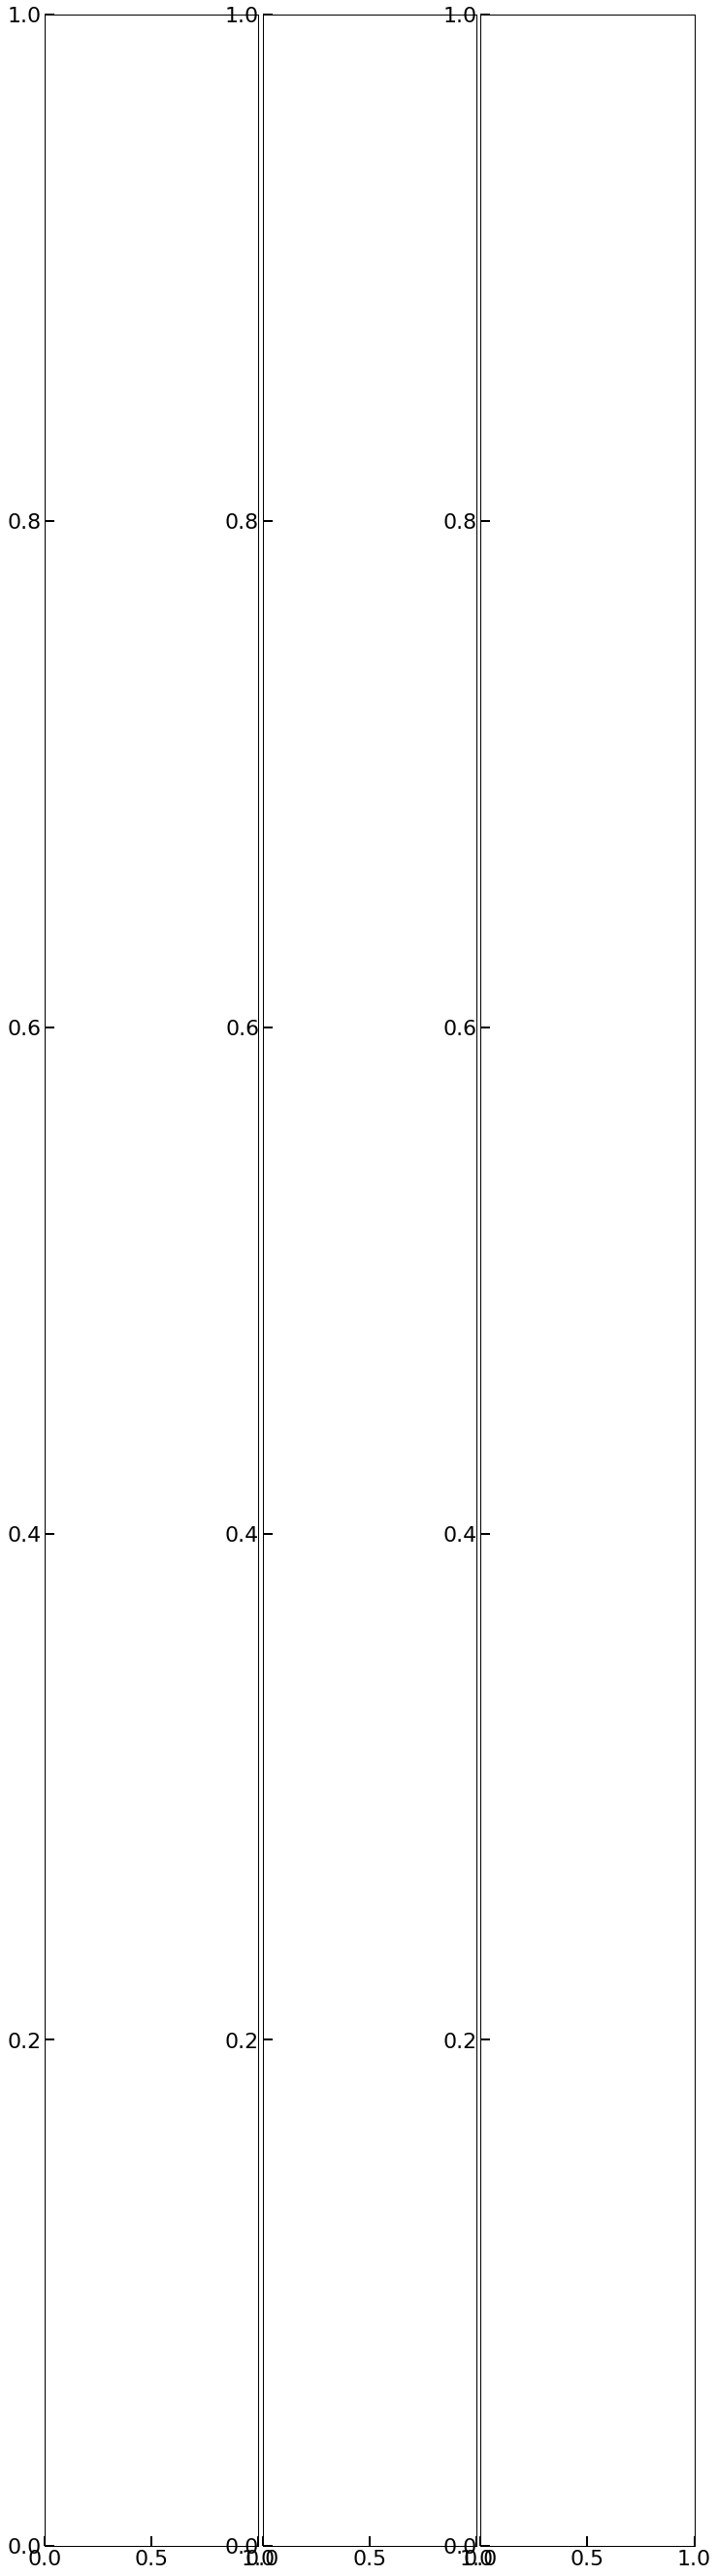

In [11]:
fig, ax = plt.subplots(1, 3, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(12, 48))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.2
dx1 = 0.25
cbtitlex = 0.1
cbtitley = 16.5
plane = (int)(ncells[1]/2)
plane = 469

proj_rho = np.sum(rho_gas*dy*vz, axis=1)

plot = ax[0].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(scalar0),\
                    norm=mcolors.LogNorm(vmin=1.e-62, vmax=1.e-57),
                    cmap='Blues')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-6,  1.e-2, 1., 1.e2))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")

plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(scalar1),\
                    norm=mcolors.LogNorm(vmin=1.e-62, vmax=1.e-57),
                    cmap='Blues')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-6,  1.e-2, 1., 1.e2))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")


plot = ax[2].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(scalar2),\
                    norm=mcolors.LogNorm(vmin=1.e-62, vmax=1.e-57),
                    cmap='Blues')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-6,  1.e-2, 1., 1.e2))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")





ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[2].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[1].plot(xrange[1]/kpc, zrange[530]/kpc, '*', color='red', markersize=12)
# ax[0].text(0.5, 0.5, '%.2f'%(ds.current_time.to('Myr')))
# plt.setp(ax, 'ylim',(-2.,6.0))
# plt.setp(ax, 'xlim',(0.6,0.8))
ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')
# ax[0].text( 0.4, 0.95, 'Res=%d'%(res) +' pc', transform = ax[0].transAxes, color='black')

# plt.setp(ax, 'ylim', (-0.01,8.))

In [29]:
np.amin(rhoZ0*dV/1.e3), dV

(4.6148159302335723e-08, 1.0486191494750978e+59)

/jobfs/132462625.gadi-pbs/ipykernel_247778/2667528599.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[0].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(rho_gas[:,plane,:])/mp,\
/jobfs/132462625.gadi-pbs/ipykernel_247778/2667528599.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(rhoZ0[:,plane,:]*dV/1.e3),\


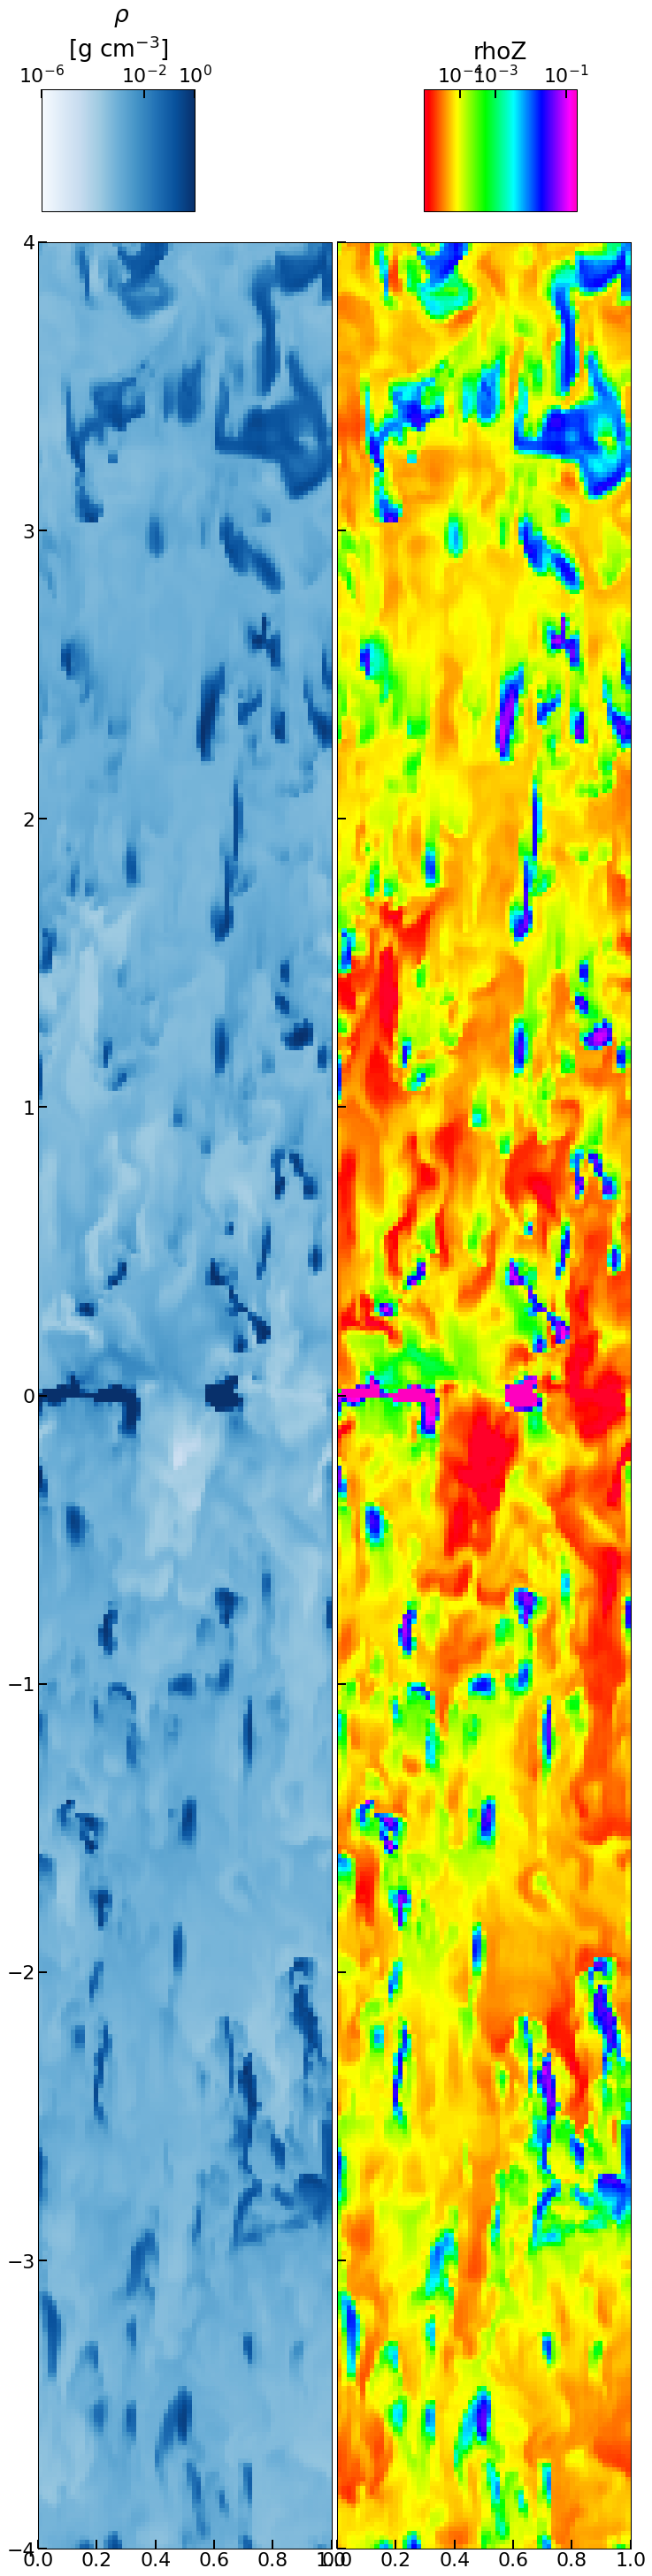

In [18]:
fig, ax = plt.subplots(1, 2, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(12, 48))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.2
dx1 = 0.25
cbtitlex = 0.1
cbtitley = 16.5
plane = (int)(ncells[1]/2)


# proj_rho = np.sum(rho_gas*dy*vz, axis=1)

plot = ax[0].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(rho_gas[:,plane,:])/mp,\
                    norm=mcolors.LogNorm(vmin=1.e-6, vmax=1.),
                    cmap='Blues')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-6,  1.e-2, 1., 1.e2))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")

# plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(temp[:,plane,:]),\
#                     norm=mcolors.LogNorm(vmin=2.e1, vmax=5.e8),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx + dx1, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e2, 1.e4,  1.e6,1.e8))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" T" + "\n" + " [K]")


# plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(np.abs(vz[:,plane,:]))/kmps,\
#                     norm=mcolors.LogNorm(vmin=2.e1, vmax=5.e8),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx + dx1, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e2, 1.e4,  1.e6,1.e8))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r"$|v_z|$" + "\n" + "1000 kmps")
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)

plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(rhoZ0[:,plane,:]*dV/1.e3),\
                    norm=mcolors.LogNorm(vmin=1.e-5, vmax=0.2),
                    cmap='gist_rainbow')
cax = fig.add_axes([cbarx + 2.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-4, 1.e-3, 1.e-1))
cax.xaxis.set_ticks_position('top')
cax.set_title(r"rhoZ" )

ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)


# plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(eint[:,plane,:]),\
#                     norm=mcolors.LogNorm(vmin=9.e-21, vmax=5.e-10),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx + 3.*dx1, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-20, 1.e-16, 1.e-10, 1.e-8))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" eint" + "\n" + " [cgs]")
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)

# # ax[1].text(0.5,0.8, "%2.1f"%(ds.current_time.to("Myr")) + ' Myr', transform=ax[1].transAxes, fontsize=12)
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)


# plot = ax[2].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(vz[:,plane,:])/kmps,\
#                     vmin=-500., vmax=500.,
#                     cmap='seismic')
# cax = fig.add_axes([cbarx + 2.*dx1, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-500.,0.0, 500.))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" vz" + "\n" + " [kmps]")

ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[2].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[1].plot(xrange[1]/kpc, zrange[530]/kpc, '*', color='red', markersize=12)
# ax[0].text(0.5, 0.5, '%.2f'%(ds.current_time.to('Myr')))
# plt.setp(ax, 'ylim',(-2.,6.0))
# plt.setp(ax, 'xlim',(0.6,0.8))
# ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')
# ax[0].text( 0.4, 0.95, 'Res=%d'%(res) +' pc', transform = ax[0].transAxes, color='black')

# plt.setp(ax, 'ylim', (-0.01,8.))

In [22]:
rhoZ0*Msun/1.e3

array([[[9.09275292e-31, 1.00911714e-30, 1.04401753e-30, ...,
         4.77618542e-31, 4.28926958e-31, 3.07669373e-31],
        [1.14844494e-30, 1.31004384e-30, 1.34850763e-30, ...,
         4.57765039e-31, 3.35229317e-31, 3.06097726e-31],
        [1.19393647e-30, 1.40505283e-30, 1.40367571e-30, ...,
         4.44483353e-31, 4.29051803e-31, 4.75707755e-31],
        ...,
        [9.42219348e-31, 9.07074182e-31, 9.04113695e-31, ...,
         5.03246207e-31, 4.97919682e-31, 4.38859171e-31],
        [9.41697488e-31, 9.11926136e-31, 8.92254106e-31, ...,
         5.00098226e-31, 4.91288320e-31, 4.33355548e-31],
        [8.33227733e-31, 8.50575249e-31, 8.56703835e-31, ...,
         4.76405134e-31, 4.84918230e-31, 3.94241527e-31]],

       [[8.74175198e-31, 9.09341096e-31, 9.07065580e-31, ...,
         4.49600320e-31, 4.47988297e-31, 3.67542239e-31],
        [1.20697707e-30, 1.33347222e-30, 1.34807158e-30, ...,
         4.86109762e-31, 4.48957531e-31, 1.03901139e-30],
        [1.15458088e-30, 

In [ ]:
abund0 = rhoZ0[:,plane,:]*Msun/rho_gas[:,plane,:]/1.e3

abund1 = rhoZ1[:,plane,:]/rhoZ0[:,plane,:]
abund2 = rhoZ2[:,plane,:]/rhoZ0[:,plane,:]


In [ ]:
np.amax(abund1),np.amin(abund1)

In [ ]:
fig, ax = plt.subplots(1, 4, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(16, 16))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.12
dx1 = 0.2
cbtitlex = 0.1
cbtitley = 16.5
plane = (int)(ncells[1]/2)



plot = ax[0].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(rho_gas[:,plane,:])/mp,\
                    norm=mcolors.LogNorm(vmin=1.e-6, vmax=1.e-1),
                    cmap='Blues')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-6,  1.e-2, 1., 1.e2))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")

plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(abund0),\
                    norm=mcolors.LogNorm(vmin=2.e-8, vmax=5.e-1),
                    cmap='afmhot')
cax = fig.add_axes([cbarx + dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-8, 1.e-6, 1.e-4, 1.e-2))
cax.xaxis.set_ticks_position('top')
cax.set_title(r"Z0")



plot = ax[2].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(abund1),\
                    norm=mcolors.LogNorm(vmin=1.e-4, vmax=1.e4),
                    cmap='Spectral')
cax = fig.add_axes([cbarx + 2.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-4, 1.e-2, 1., 1.e2, 1.e4))
cax.xaxis.set_ticks_position('top')
cax.set_title(r"$\rho_{\rm Type1a}/\rho_{Z0}$" )

plot = ax[3].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(abund2),\
                    norm=mcolors.LogNorm(vmin=1.e-4, vmax=1.e4),
                    cmap='Spectral')
cax = fig.add_axes([cbarx + 3.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-4, 1.e-2, 1., 1.e2, 1.e4))
cax.xaxis.set_ticks_position('top')
cax.set_title(r"$\rho_{\rm AGB}/\rho_{Z0}$" )

ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
ax[2].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
ax[3].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[1].plot(xrange[1]/kpc, zrange[530]/kpc, '*', color='red', markersize=12)
# ax[0].text(0.5, 0.5, '%.2f'%(ds.current_time.to('Myr')))
# plt.setp(ax, 'ylim',(-2.,6.0))
# plt.setp(ax, 'xlim',(0.6,0.8))
ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')
# ax[0].text( 0.4, 0.95, 'Res=%d'%(res) +' pc', transform = ax[0].transAxes, color='black')

plt.setp(ax, 'ylim', (-0.01,4.))

In [ ]:
1.0706877673e+09/yr_to_sec
